In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [3]:
train_df = pd.read_csv('골밀도 데이터/train_data.csv')
train_df = train_df[['No', '성별', 'boneage']]
train_df.columns = ['id', 'gender', 'boneage']
train_df['id'] = train_df['id'].astype('str')

mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()

train_df['boneage_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

train_df.head()

,id,gender,boneage,boneage_z
0,98.jpg,F,12.125,0.615059
1,1162.jpg,M,7.125,-0.634581
2,636.jpg,M,10.500,0.208926
3,990.jpg,M,4.125,-1.384365
4,618.jpg,M,9.625,-0.009761


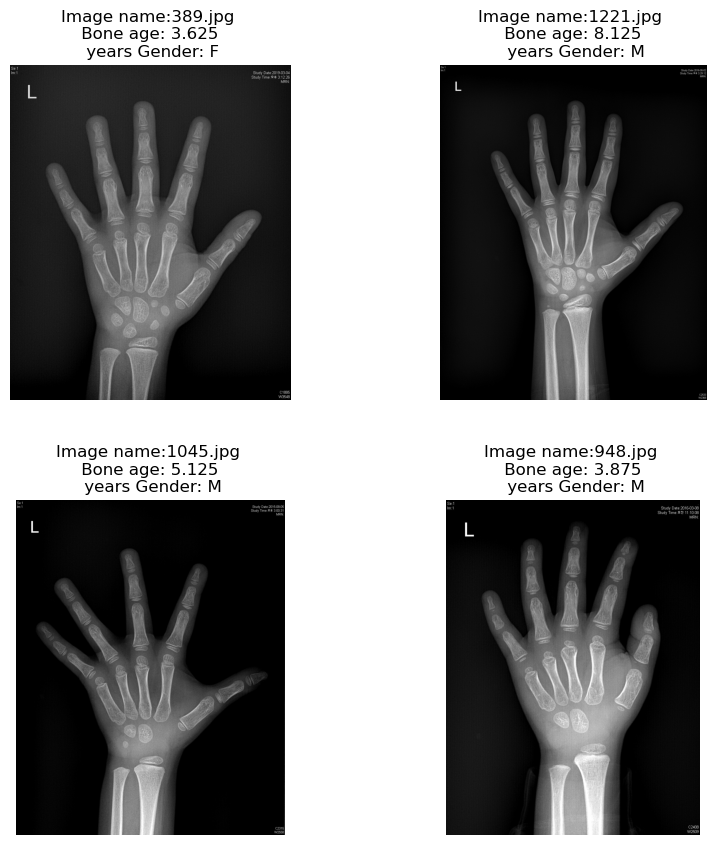

In [4]:
import matplotlib.image as mping
fig, axes = plt.subplots(2,2, figsize = (10, 10))
plt.subplots_adjust(hspace=0.3)
i = 0
for filename, boneage, gender in train_df[['id', 'boneage', 'gender']].sample(4).values:
    img = mping.imread('골밀도 데이터/train_image/' + str(filename))
    axes[i//2,i%2].imshow(img)
    axes[i//2,i%2].set_title('Image name:{} \n Bone age: {} \n years Gender: {}'.format(filename, boneage, gender))
    axes[i//2,i%2].axis('off')
    i += 1
    
plt.show()

## 2. 이미지 전처리

In [5]:
train_path = '골밀도 데이터/train_image/'
test_path = '골밀도 데이터/test_image/'

Grayscale

(1572, 1184)


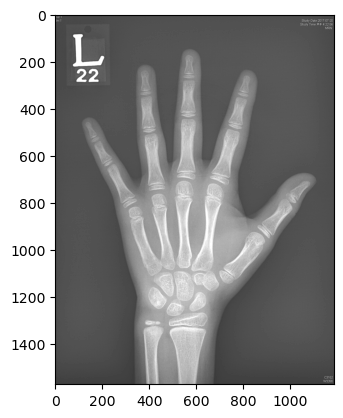

In [8]:
img = cv2.imread(train_path + '1.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, 'gray')
plt.show()

Resize

In [18]:
ratio = 0
for i in range(len(train_df.id)):
    img = cv2.imread(train_path + train_df['id'][i], cv2.IMREAD_GRAYSCALE)
    ratio += img.shape[0] / img.shape[1]

ratio / len(train_df.id)

1.2670239792012663

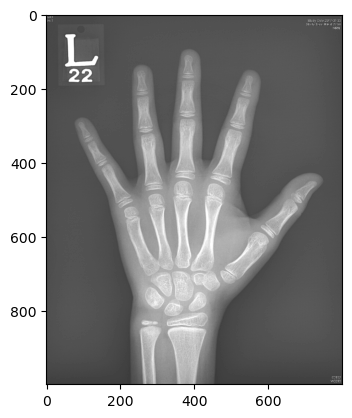

In [10]:
# 이미지 사이즈 재설정
resize_img = cv2.resize(img, (800, 1000))
plt.imshow(resize_img, 'gray')

Normalize

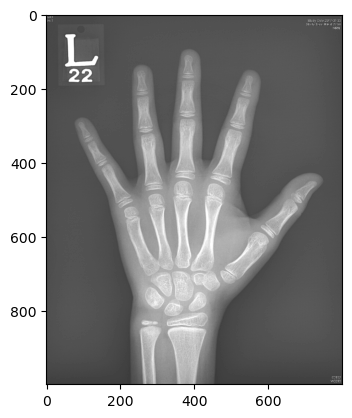

In [11]:
# 이미지 min max 정규화
normal_img = cv2.normalize(resize_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img, 'gray')

Denoise

In [ ]:
# denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 10, 5, 15)
# plt.imshow(denoise_img,"gray")

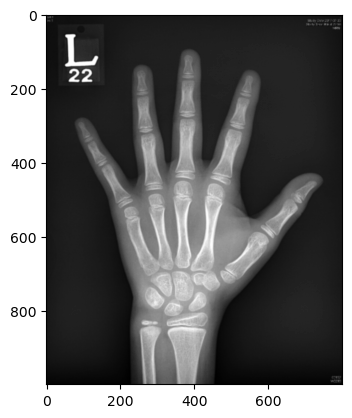

In [67]:
denoise_img = cv2.GaussianBlur(normal_img, (5, 5), 0)
plt.imshow(denoise_img,"gray")

Equalize

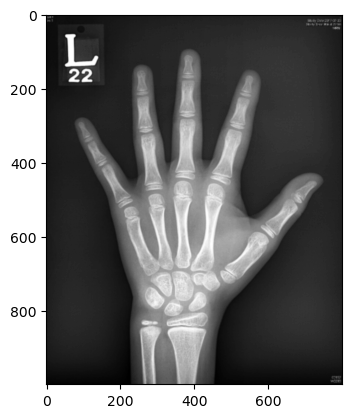

In [70]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img, 'gray')

In [10]:
pre_train_image_folder = '골밀도 데이터/pre_train_image/'
os.makedirs(pre_train_image_folder, exist_ok=True)

In [19]:
# fig, ax = plt.subplots(2,2, figsize = (10, 10))
for i in range(0, train_df.shape[0]):
    img_path = glob.glob(train_path + train_df.id[i])[0]
    
    img_name = img_path.split('/')[-1]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # 이미지 사이즈 재설정
    resized_img = cv2.resize(img, (800, 1000))
    # ax[0,0].imshow(resized_img, 'gray')
    
    # 이미지 정규화
    normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    # ax[0,1].imshow(normal_img, 'gray')
    
    # 이미지 노이즈 제거
    denoise_img = cv2.GaussianBlur(normal_img, (5, 5), 0)
    # ax[1,0].imshow(denoise_img, 'gray')
    
    # 이미지 평탄화
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    equal_img=clahe.apply(denoise_img)
    # ax[1,1].imshow(equal_img, 'gray')
    
    # 이미지 저장
    cv2.imwrite(pre_train_image_folder + img_name, equal_img)

## 3. 이미지 회전
+ 여기서부터 시작

In [21]:
data = pd.read_csv('골밀도 데이터/train_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


### 샘플이미지 회전

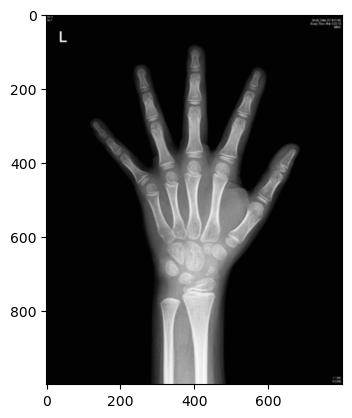

In [120]:
temp_img = cv2.imread('골밀도 데이터/pre_train_image/1227.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(temp_img, 'gray')

샘플이미지 Thresholding
+ 0 ~ 255 사이로

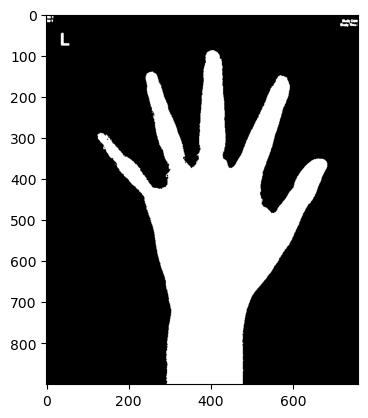

In [121]:
r_img = np.copy(temp_img)
height, width = temp_img.shape
img = temp_img[0:(int)(height*0.9),0:(int)(width*0.95)]

# 픽셀 값의 평균 크면 255로 설정되고 작으면 0으로 설정정
ret, img = cv2.threshold(img, temp_img.mean(), 255, cv2.THRESH_BINARY)

#샘플 이미지 Thresholding 결과
plt.imshow(img,"gray")

### 이미지 contouring

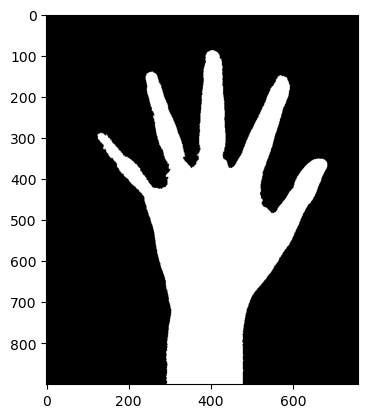

In [122]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#외곽선 검출하여 mask 그리기
max_cnt = max(contours, key=cv2.contourArea)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

plt.imshow(mask, 'gray')

### 첫 번째 흰색 좌표 구하기
+ 첫 번째 흰색 좌표가 중지 끝임

In [123]:
M = cv2.moments(max_cnt)
center = (int(M['m10']/M['m00']), int(M['m01']/M['m00']))

for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[len(x_255_indexs)//2]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break
        
print((first_255_x_point,first_255_y_point))
        

(404, 88)


### 무게중심과 좌표의 각도 구하여 회전

In [124]:
# 이미지 회전 함수 정의
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

In [127]:
# 무게중심과 첫 흰색 좌표 차이
center_x, center_y = center[0], center[1]
rx = abs(first_255_x_point - center_x)
ry = center_y - first_255_y_point

# 회전 각도 구하기
import math
radian = math.atan2(ry, rx)
degree = 90 - math.degrees(radian)

# 무게중심과 첫 좌표 위치에 따라 회전 방향 조정

if first_255_x_point < center_x :
    mask = rotate_image(mask,360-degree) 
    r_img_ = rotate_image(temp_img,360-degree)
else:
    mask = rotate_image(mask,degree) 
    r_img_ = rotate_image(temp_img,degree) 

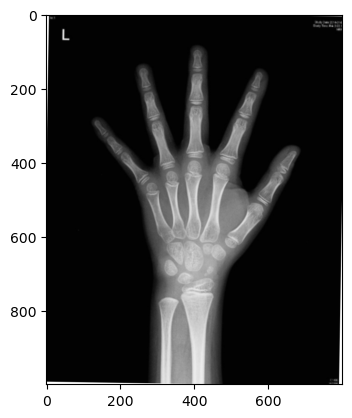

In [128]:
plt.imshow(r_img_, 'gray')

### 전체 이미지 회전